In [1]:
%%html
<style>
#notebook-container {
    width: 90%;
    background-color: #EEE
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .output_wrapper {
    width: 50%;
    background-color: #FFF
}

.code_cell .input {
    width: 50%;
    background-color: #FFF
}
</style>

In [5]:
clear all
A = [ 0 1 0; 0 0 1; -2 -4 -3];
B = [0 0; 0 1; 1 0];
C = [1 0 0; 0 1 0];
ST = 0.001;
sys = ss(A,B,C,[]);
sysd = c2d(sys,ST)


sysd =
 
  A = 
              x1         x2         x3
   x1          1      0.001  4.995e-07
   x2  -9.99e-07          1  0.0009985
   x3  -0.001997  -0.003995      0.997
 
  B = 
               u1          u2
   x1   1.665e-10       5e-07
   x2   4.995e-07       0.001
   x3   0.0009985  -1.998e-06
 
  C = 
       x1  x2  x3
   y1   1   0   0
   y2   0   1   0
 
  D = 
       u1  u2
   y1   0   0
   y2   0   0
 
サンプル時間:  0.001 seconds
離散時間状態空間モデル。




## 拡大系を組む

4サンプルをひとまとめとして拡大系を組む。
極が早すぎると失敗したりする…

In [6]:
% Extended system
A_ = sysd.A^4;
c1 = sysd.C(1,:); c2 = sysd.C(2,:);
C_= [c1;c2;c2*sysd.A^2];

In [7]:
P = [-1 -1.5 -2];
%P = [-2 -3 -4];
K_ = place(A_',C_',exp(P*ST*4))'
k1 = K_(:,1); k21 = K_(:,2); k22 = K_(:,3);


K_ =

    0.3258    0.0297    0.3616
   -0.0594   -1.1023    1.4222
   -0.4834    0.9801   -2.0574




kゲインの変換を行う

In [134]:
W4 = sysd.A';
W3 = sysd.A'*W4 - c2'*k22';
W2 = sysd.A'*W3;
% conversion
k1_ = inv(W2)'*k1
k21_ = inv(W2)'*k21
k22_ = inv(W4)'*k22


k1_ =

    0.3280
   -0.0077
   -0.7217


k21_ =

    0.1586
    1.7694
   -2.2920


k22_ =

    0.2092
    1.6257
   -2.0007




計算したkgainについて極を計算する。

In [135]:
log(eig(sysd.A*(sysd.A-[k1_ k21_]*sysd.C)*sysd.A*(sysd.A-[zeros(3,1) k22_]*sysd.C)))/ST



ans =

   -4.0000
   -8.0000
   -6.0000




In [3]:
%% Make Data with noise
Kreg = place(sysd.A,sysd.B,exp(ST*[-1,-1,-0.5]));
Kreg = zeros(2,3);
% sim setting
len = 200;
time = 0:ST:ST*(len-1);
x_gt = zeros(3,len);
x_obs = zeros(3,len); 
x_obs2 = zeros(3,len);

% noise variable 
sigma1 = 0.11;
sigma2 = 0.22;
Noise = [sigma1;sigma2] .* randn(2,len);

% init
x_gt(:,1) = [1;-2;3];
x_obs(:,1) = [-1;2;-3]; % converted 
x_obs2(:,1) = [-1;2;-3]; % Non-converted
u1 = sin(1*pi/3*time);
u2 = sin(2*pi/3*time);
U = [u1;u2];

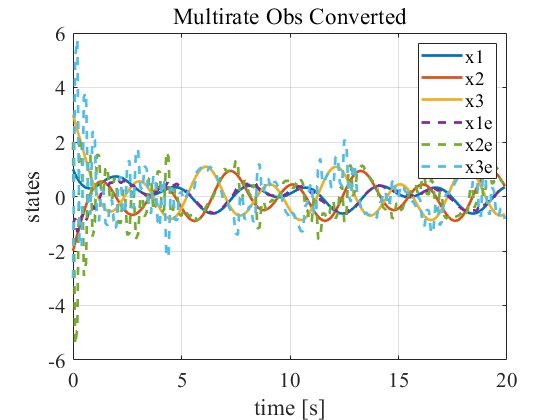

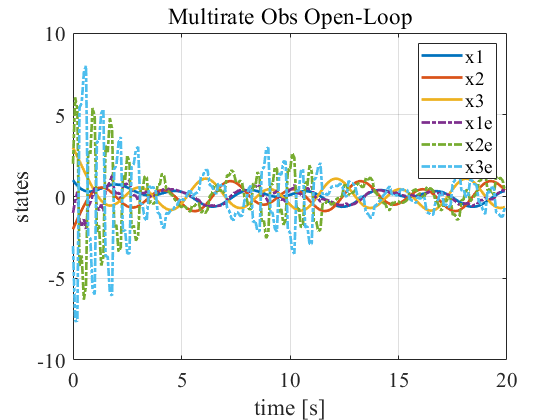

In [136]:

for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i-1)+Noise(:,i-1);
    % Observation
    if mod(i,4) == 2
        x_obs_hat = sysd.A * x_obs(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        x_obs2_hat = sysd.A * x_obs2(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs_hat = sysd.C * x_obs(:,i-1);
        yobs2_hat = sysd.C * x_obs2(:,i-1);
        x_obs(:,i) = x_obs_hat + [k1_ k21_]*(y-yobs_hat);
        x_obs2(:,i) = x_obs2_hat + [k1 k21]*(y-yobs2_hat);                
    elseif mod(i,4) == 0
        x_obs_hat = sysd.A * x_obs(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        x_obs2_hat = sysd.A * x_obs2(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs_hat = sysd.C * x_obs(:,i-1);
        yobs2_hat = sysd.C * x_obs2(:,i-1);
        x_obs(:,i) = x_obs_hat + [zeros(3,1) k22_]*(y-yobs_hat);
        x_obs2(:,i) = x_obs2_hat + [zeros(3,1) k22]*(y-yobs2_hat);
    else
        x_obs(:,i) = sysd.A * x_obs(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        x_obs2(:,i) = sysd.A * x_obs2(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    end   
end

fig = figure;
plot(time,x_gt,time,x_obs2,'-.')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Multirate Obs Open-Loop')
grid on
xlabel('time [s]')
ylabel('states')

fig = figure;
plot(time,x_gt,time,x_obs,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Multirate Obs Converted')
grid on
xlabel('time [s]')
ylabel('states')


In [138]:
Knom3 = place(A_',sysd.C',exp(ST*4*P))';
Knom4 = place((sysd.A')^2,sysd.C',exp(ST*2*P))';
Knom5 = place(sysd.A',sysd.C',exp(ST*P))';

P_obs3 = zeros(3,3,len);
P_obs4 = zeros(3,3,len);
P_obs5 = zeros(3,3,len);


x_obs3 = zeros(3,len);
x_obs3(:,1) = [-1;2;-3]; % without multirate
x_obs4 = zeros(3,len);
x_obs4(:,1) = [-1;2;-3]; % without multirate
x_obs5 = zeros(3,len);
x_obs5(:,1) = [-1;2;-3]; % without multirate


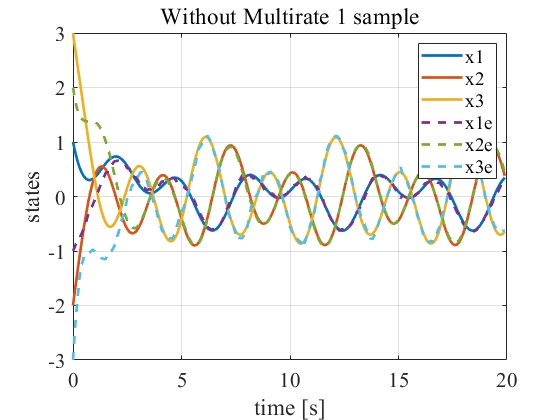

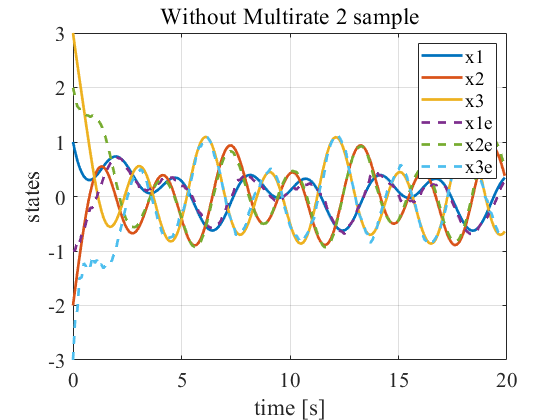

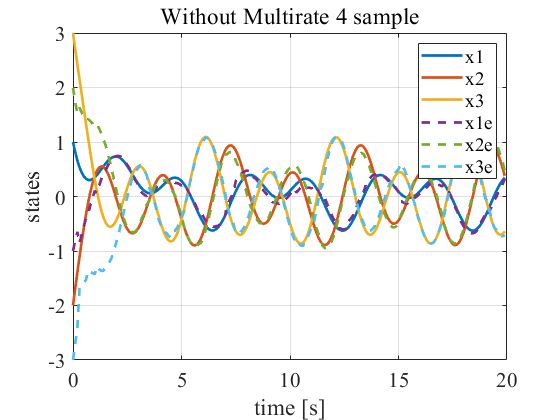

In [195]:
%% observer style
Knom3 = place(A_',sysd.C',exp(ST*4*P))';
Knom4 = place((sysd.A')^2,sysd.C',exp(ST*2*P))';
Knom5 = place(sysd.A',sysd.C',exp(ST*P))';

P_obs3 = zeros(3,3,len);
P_obs4 = zeros(3,3,len);
P_obs5 = zeros(3,3,len);
W = diag([sigma1^2,sigma2^2]);


x_obs3 = zeros(3,len);
x_obs3(:,1) = [-1;2;-3]; % without multirate
x_obs4 = zeros(3,len);
x_obs4(:,1) = [-1;2;-3]; % without multirate
x_obs5 = zeros(3,len);
x_obs5(:,1) = [-1;2;-3]; % without multirate

for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i-1)+Noise(:,i-1);
    % Observation
    if mod(i,4) == 0
        x_obs3_hat = sysd.A * x_obs3(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs3_hat = sysd.C * x_obs3(:,i-1);
        x_obs3(:,i) = x_obs3_hat + Knom3*(y-yobs3_hat);
        P_obs3(:,:,i) = (sysd.A-Knom3*sysd.C)*P_obs3(:,:,i-1)*(sysd.A-Knom3*sysd.C)'+Knom3*W*Knom3';
        x_obs4_hat = sysd.A * x_obs4(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs4_hat = sysd.C * x_obs4(:,i-1);
        x_obs4(:,i) = x_obs4_hat + Knom4*(y-yobs4_hat);                
        P_obs4(:,:,i) = (sysd.A-Knom4*sysd.C)*P_obs4(:,:,i-1)*(sysd.A-Knom4*sysd.C)'+Knom4*W*Knom4';

    elseif mod(i,2) == 0
        x_obs3(:,i) = sysd.A * x_obs3(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        P_obs3(:,:,i) = sysd.A*P_obs3(:,:,i-1)*sysd.A';
        x_obs4_hat = sysd.A * x_obs4(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        yobs4_hat = sysd.C * x_obs4(:,i-1);
        x_obs4(:,i) = x_obs4_hat + Knom4*(y-yobs4_hat);                
        P_obs4(:,:,i) = (sysd.A-Knom4*sysd.C)*P_obs4(:,:,i-1)*(sysd.A-Knom4*sysd.C)'+Knom4*W*Knom4';

    else
        x_obs3(:,i) = sysd.A * x_obs3(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        P_obs3(:,:,i) = sysd.A*P_obs3(:,:,i-1)*sysd.A';
        x_obs4(:,i) = sysd.A * x_obs4(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
        P_obs4(:,:,i) = sysd.A*P_obs4(:,:,i-1)*sysd.A';
    end
    x_obs5_hat = sysd.A * x_obs5(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    yobs5_hat = sysd.C * x_obs5(:,i-1);
    x_obs5(:,i) = x_obs5_hat + Knom5*(y-yobs5_hat);
    P_obs5(:,:,i) = (sysd.A-Knom5*sysd.C)*P_obs5(:,:,i-1)*(sysd.A-Knom5*sysd.C)'+Knom5*W*Knom5';

end

fig=figure;
plot(time,x_gt,time,x_obs3,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Without Multirate 4 sample')
grid on
xlabel('time [s]')
ylabel('states')

fig=figure;
plot(time,x_gt,time,x_obs4,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Without Multirate 2 sample')
grid on
xlabel('time [s]')
ylabel('states')

fig=figure;
plot(time,x_gt,time,x_obs5,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Without Multirate 1 sample')
grid on
xlabel('time [s]')
ylabel('states')


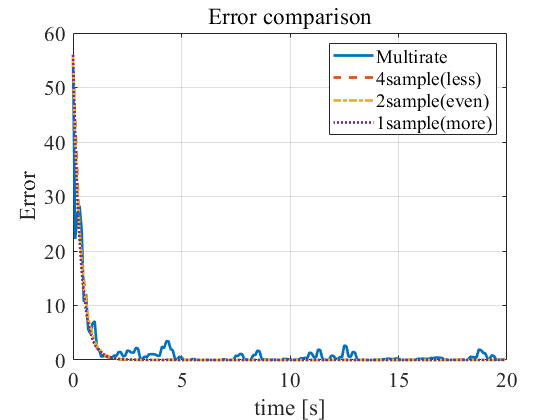

In [143]:
figure
plot(time',diag((x_gt-x_obs)'*(x_gt-x_obs)),time',diag((x_gt-x_obs3)'*(x_gt-x_obs3)),'--',time',diag((x_gt-x_obs4)'*(x_gt-x_obs4)),'-.',time',diag((x_gt-x_obs5)'*(x_gt-x_obs5)),':')
grid on
title('Error comparison')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')
ylabel('Error')

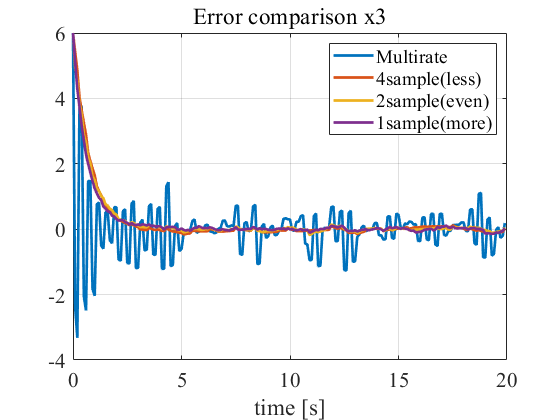

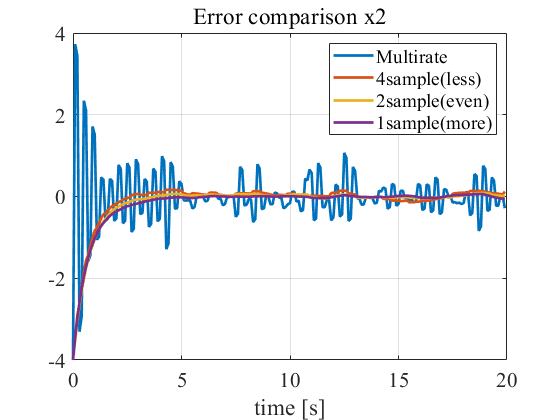

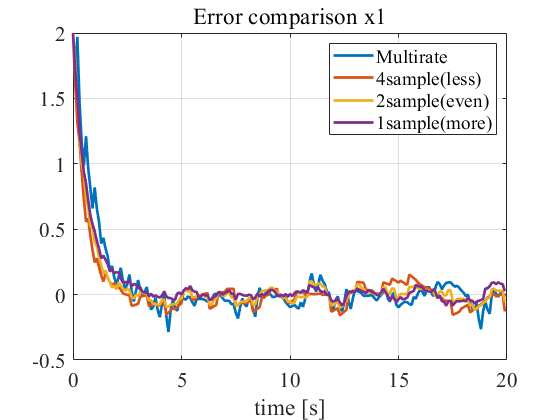

In [144]:
%% errors

e_obs = (x_gt-x_obs);
e_obs3 = (x_gt-x_obs3);
e_obs4 = (x_gt-x_obs4);
e_obs5 = (x_gt-x_obs5);

figure
plot(time',e_obs(1,:),time',e_obs3(1,:),time',e_obs4(1,:),time',e_obs5(1,:))
grid on
title('Error comparison x1')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

figure
plot(time',e_obs(2,:),time',e_obs3(2,:),time',e_obs4(2,:),time',e_obs5(2,:))
grid on
title('Error comparison x2')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

figure
plot(time',e_obs(3,:),time',e_obs3(3,:),time',e_obs4(3,:),time',e_obs5(3,:))
grid on
title('Error comparison x3')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

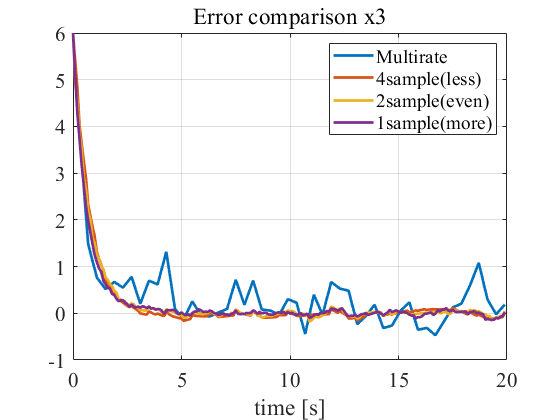

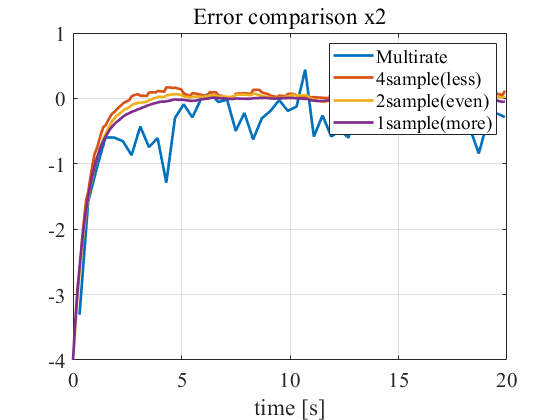

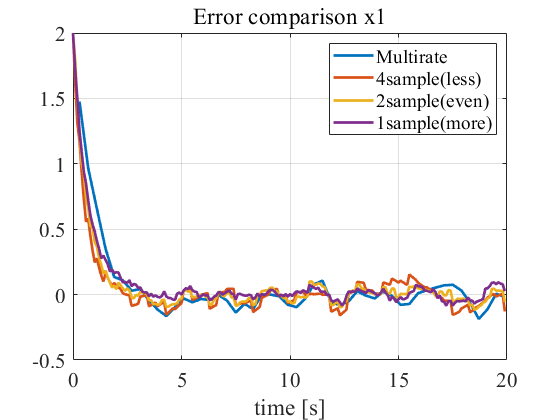

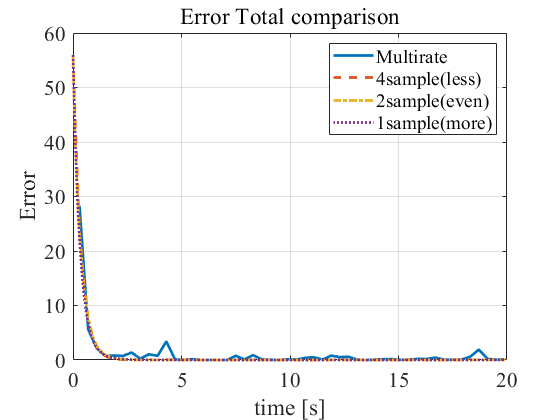

In [161]:
time_ = [];
e_obs_ = [];
for i=1:len
    if mod(i,4)==0
        time_ = [time_;time(i)];
        e_obs_ = [e_obs_,e_obs(:,i)];
    end
end

figure
plot(time_,diag(e_obs_'*e_obs_),time',diag((x_gt-x_obs3)'*(x_gt-x_obs3)),'--',time',diag((x_gt-x_obs4)'*(x_gt-x_obs4)),'-.',time',diag((x_gt-x_obs5)'*(x_gt-x_obs5)),':')
grid on
title('Error Total comparison')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')
ylabel('Error')

figure
plot(time_,e_obs_(1,:),time',e_obs3(1,:),time',e_obs4(1,:),time',e_obs5(1,:))
grid on
title('Error comparison x1')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

figure
plot(time_,e_obs_(2,:),time',e_obs3(2,:),time',e_obs4(2,:),time',e_obs5(2,:))
grid on
title('Error comparison x2')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

figure
plot(time_,e_obs_(3,:),time',e_obs3(3,:),time',e_obs4(3,:),time',e_obs5(3,:))
grid on
title('Error comparison x3')
legend('Multirate','4sample(less)','2sample(even)','1sample(more)')
xlabel('time [s]')

## 解析： 計算による共分散の推定値と実測の共分散が一致するか？

- 例１

実測の誤差共分散

```
[0.0020    0.0008    0.0033]
```

行列

```
Pend5_ =

    0.0019   -0.0012   -0.0016
   -0.0012    0.0016    0.0000
   -0.0016    0.0000    0.0027
```

近い…？

- 例２

実測

```
0.0010    0.0004    0.0018
```

共分散行列

```
Pend5 =

    0.0023   -0.0015   -0.0019
   -0.0015    0.0019    0.0001
   -0.0019    0.0001    0.0032
```

実測其の２

```
0.0012    0.0005    0.0019
```

### 解析結果
どうも誤差の共分散行列は一回の施行には該当しないっぽい？

In [196]:
%% errors

e_obs = (x_gt-x_obs);
e_obs3 = (x_gt-x_obs3);
e_obs4 = (x_gt-x_obs4);
e_obs5 = (x_gt-x_obs5);

[var(e_obs3(1,100:end)'),var(e_obs3(2,100:end)'),var(e_obs3(3,100:end)')]
[var(e_obs4(1,100:end)'),var(e_obs4(2,100:end)'),var(e_obs4(3,100:end)')]
[var(e_obs5(1,100:end)'),var(e_obs5(2,100:end)'),var(e_obs5(3,100:end)')]

[mean(e_obs3(1,100:end)'),mean(e_obs3(2,100:end)'),mean(e_obs3(3,100:end)')]
[mean(e_obs4(1,100:end)'),mean(e_obs4(2,100:end)'),mean(e_obs4(3,100:end)')]
[mean(e_obs5(1,100:end)'),mean(e_obs5(2,100:end)'),mean(e_obs5(3,100:end)')]



ans =

    0.0060    0.0081    0.0052


ans =

    0.0036    0.0030    0.0037


ans =

    0.0010    0.0004    0.0018


ans =

    0.0169   -0.0099    0.0026


ans =

    0.0400   -0.0349   -0.0007


ans =

    0.0131   -0.0082   -0.0054




In [239]:
W = diag([sigma1^2,sigma2^2]);

Cnom3=Knom3*W*Knom3';
Pend3 = sylvester(inv(A_-Knom3*sysd.C),-(A_-Knom3*sysd.C)',(A_-Knom3*sysd.C)\Cnom3)
Pend3 = dlyap((A_-Knom3*sysd.C),Cnom3)
Cnom4=sysd.A*Knom4*W*Knom4'*sysd.A';
Pend4 = sylvester(inv(((sysd.A-Knom4*sysd.C)*sysd.A)),-((sysd.A-Knom4*sysd.C)*sysd.A)',((sysd.A-Knom4*sysd.C)*sysd.A)\Cnom4)
Cnom5=Knom5*W*Knom5';
Pend5 = sylvester(inv(sysd.A-Knom5*sysd.C),-(sysd.A-Knom5*sysd.C)',(sysd.A-Knom5*sysd.C)\Cnom5)



Pend3 =

    0.0070   -0.0057   -0.0031
   -0.0057    0.0070   -0.0006
   -0.0031   -0.0006    0.0058


Pend3 =

    0.0070   -0.0057   -0.0031
   -0.0057    0.0070   -0.0006
   -0.0031   -0.0006    0.0058


Pend4 =

    0.0043   -0.0037   -0.0018
   -0.0037    0.0047   -0.0006
   -0.0018   -0.0006    0.0037


Pend5 =

    0.0023   -0.0015   -0.0019
   -0.0015    0.0019    0.0001
   -0.0019    0.0001    0.0032




In [198]:
Pend3_ = P_obs3(:,:,end)
Pend4_ = P_obs4(:,:,end)
Pend5_ = P_obs5(:,:,end)

W


Pend3_ =

    0.0082   -0.0073   -0.0026
   -0.0073    0.0089   -0.0012
   -0.0026   -0.0012    0.0064


Pend4_ =

    0.0047   -0.0034   -0.0030
   -0.0034    0.0043   -0.0001
   -0.0030   -0.0001    0.0054


Pend5_ =

    0.0023   -0.0015   -0.0019
   -0.0015    0.0019    0.0001
   -0.0019    0.0001    0.0032


W =

    0.0121         0
         0    0.0484




平均が違うってことではないだろうか？
→ 違うわ

In [203]:
[e_obs5(1,100:end)*e_obs5(1,100:end)'/(len-100+1),
e_obs5(2,100:end)*e_obs5(2,100:end)'/(len-100+1),
e_obs5(3,100:end)*e_obs5(3,100:end)'/(len-100+1)]'


ans =

    0.0012    0.0005    0.0019




## フィルタタイプのオブザーバならどうなる

結論から言うと誤差の共分散を出せるわけではない。

In [69]:
%% debug with filter type observer
Knom5_ = place(sysd.A',sysd.A'*sysd.C',exp(ST*P))';
P_obs5_ = zeros(3,3,len);

Noise = [sigma1;sigma2] .* randn(2,len);

for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i-1)+Noise(:,i-1);

    x_obs5_hat = sysd.A * x_obs5(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    yobs5_hat = sysd.C * x_obs5_hat;
    x_obs5(:,i) = x_obs5_hat + Knom5_*(y-yobs5_hat);
    P_obs5_(:,:,i) = (sysd.A-Knom5_*sysd.C*sysd.A)*P_obs5_(:,:,i-1)*(sysd.A-Knom5_*sysd.C*sysd.A)'+Knom5_*W*Knom5_';

end

log(eig(sysd.A-Knom5_*sysd.C*sysd.A))/ST


ans =

   -1.0000
   -1.5000
   -2.0000




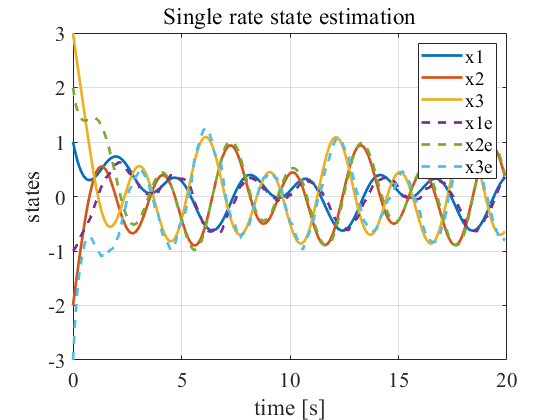

In [70]:
fig=figure;
plot(time,x_gt,time,x_obs5,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Single rate state estimation')
grid on
xlabel('time [s]')
ylabel('states')
SaveFigPDF(fig,'SingleRateOBS.pdf')

In [217]:

e_obs5 = (x_gt-x_obs5);


[var(e_obs5(1,100:end)'),var(e_obs5(2,100:end)'),var(e_obs5(3,100:end)')]

[e_obs5(1,100:end)*e_obs5(1,100:end)'/(len-100+1),
e_obs5(2,100:end)*e_obs5(2,100:end)'/(len-100+1),
e_obs5(3,100:end)*e_obs5(3,100:end)'/(len-100+1)]'

Pend5_= P_obs5_(:,:,end)
Cnom5=Knom5_*W*Knom5_';
Pend5 = sylvester(inv(sysd.A-Knom5_*sysd.C*sysd.A),-(sysd.A-Knom5_*sysd.C*sysd.A)',(sysd.A-Knom5_*sysd.C*sysd.A)\Cnom5)



ans =

    0.0059    0.0025    0.0117


ans =

    0.0059    0.0026    0.0116


Pend5_ =

    0.0027   -0.0015   -0.0027
   -0.0015    0.0021   -0.0000
   -0.0027   -0.0000    0.0049


Pend5 =

    0.0027   -0.0015   -0.0027
   -0.0015    0.0021   -0.0000
   -0.0027   -0.0000    0.0049




In [17]:
%% observer style
Knom3 = place(A_',sysd.C',exp(ST*4*P))';
Knom4 = place((sysd.A')^2,sysd.C',exp(ST*2*P))';
Knom5 = place(sysd.A',sysd.C',exp(ST*P))';

P_obs3 = zeros(3,3,len);
P_obs4 = zeros(3,3,len);
P_obs5 = zeros(3,3,len);
W = diag([sigma1^2,sigma2^2]);


x_obs3 = zeros(3,len);
x_obs3(:,1) = [-1;2;-3]; % without multirate
x_obs4 = zeros(3,len);
x_obs4(:,1) = [-1;2;-3]; % without multirate
x_obs5 = zeros(3,len);
x_obs5(:,1) = [-1;2;-3]; % without multirate

### 複数回施行で比較しないと

誤差は以前の誤差に影響されるので平行にたくさんシミュレーションして其の結果について平均的なことしないと。

- パターン１

300回のTrial平均

オブザーバのErrorの300回の分散：

```
0.0026    0.0020    0.0048
```

誤差共分散

```
0.0026   -0.0014   -0.0026
   -0.0014    0.0020   -0.0000
   -0.0026   -0.0000    0.0048
```


提案法の計算に依る誤差共分散行列

```
Pend5 =

    0.0027   -0.0015   -0.0027
   -0.0015    0.0021   -0.0000
   -0.0027   -0.0000    0.0049
```

これにて実機での推定ができる。

In [15]:
P_obs5_ = zeros(3,3,len);

%% simulation loop
simloop = 300;

x_obs5_loop = zeros(3,simloop);
e_obs5_loop = zeros(3,simloop);

for j = 1:simloop
Noise = [sigma1;sigma2] .* randn(2,len);

for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i)+Noise(:,i);

    x_obs5_hat = sysd.A * x_obs5(:,i-1) + sysd.B*Kreg*x_gt(:,i-1) + sysd.B*U(:,i);
    yobs5_hat = sysd.C * x_obs5_hat;
    x_obs5(:,i) = x_obs5_hat + Knom5_*(y-yobs5_hat);
    %P_obs5_(:,:,i) = (sysd.A-Knom5_*sysd.C*sysd.A)*P_obs5_(:,:,i-1)*(sysd.A-Knom5_*sysd.C*sysd.A)'+Knom5_*W*Knom5_';
end
x_obs5_loop(:,j) = x_obs5(:,end); 
e_obs5_loop(:,j) = x_gt(:,end)-x_obs5(:,end); 
end

関数または変数 'x_obs5' が未定義です。



In [237]:
var(e_obs5_loop')
mean(e_obs5_loop')
var(x_obs5_loop')
mean(x_obs5_loop')

e_obs5_loop(1,:)*e_obs5_loop(1,:)'/simloop
e_obs5_loop(2,:)*e_obs5_loop(2,:)'/simloop
e_obs5_loop(3,:)*e_obs5_loop(3,:)'/simloop

e_obs5_loop*e_obs5_loop'/simloop


ans =

    0.0026    0.0020    0.0048


ans =

   1.0e-03 *

   -0.2456    0.0441    0.5590


ans =

    0.0026    0.0020    0.0048


ans =

    0.3465    0.3794   -0.6417


ans =

    0.0026


ans =

    0.0020


ans =

    0.0048


ans =

    0.0026   -0.0014   -0.0026
   -0.0014    0.0020   -0.0000
   -0.0026   -0.0000    0.0048




In [36]:
Cnom5=Knom5_*W*Knom5_';
Pend5 = sylvester(inv(sysd.A-Knom5_*sysd.C*sysd.A),-(sysd.A-Knom5_*sysd.C*sysd.A)',(sysd.A-Knom5_*sysd.C*sysd.A)\Cnom5)
Pend5 = dlyap(sysd.A-Knom5_*sysd.C*sysd.A,Cnom5)

diag(Pend5)'


Pend5 =

    0.0027   -0.0015   -0.0027
   -0.0015    0.0021   -0.0000
   -0.0027   -0.0000    0.0049


Pend5 =

    0.0027   -0.0015   -0.0027
   -0.0015    0.0021   -0.0000
   -0.0027   -0.0000    0.0049


ans =

    0.0027    0.0021    0.0049




# センサ選択との連携？
センサを増やしたり減らしたりするとどうなる？

- センサ減らしたVer

誤差の大きい速度センサをへらすとどうなる

```
 0.0005    0.0013    0.0011
```

- 元の共分散

```
 0.0027    0.0021    0.0049
```


単センサの方が共分散低く推定できるのはちょっと…


In [33]:
C1=[1 0 0];
K1_ = place(sysd.A',sysd.A'*C1',exp(P*ST))'
display(Knom5_)


K1_ =

    0.1393
   -0.1859
    0.0932


Knom5_ =

    0.1391    0.0939
    0.0044   -0.0003
   -0.1885   -0.1905




In [35]:
Cnom5_red=K1_*W(1)*K1_';
Pend5_red = dlyap(sysd.A-K1_*C1*sysd.A,Cnom5_red)

diag(Pend5_red)'


Pend5_red =

    0.0005   -0.0008    0.0005
   -0.0008    0.0013   -0.0011
    0.0005   -0.0011    0.0011


ans =

    0.0005    0.0013    0.0011




## 定常カルマンフィルタとの比較

定常カルマンフィルタならどうなるか？
リアプノフ方程式を解いて比較したかったが片方が0になってしまう…

In [50]:
[X,L,G,report] = dare(sysd.A',sysd.C',zeros(size(A)),W)

[Xr,Lr,Gr,report_r] = dare(sysd.A',C1',zeros(size(A)),W(1:1,1:1))


X =

   1.0e-17 *

    0.0000   -0.0392    0.3712
   -0.0392    0.0328    0.9227
    0.3712    0.9227   -0.3332


L =

   0.9003 + 0.0903i
   0.9003 - 0.0903i
   0.9048 + 0.0000i


G =

   1.0e-15 *

   -0.0018   -0.0055    0.2336
   -0.0066    0.0231    0.1371


report =

   7.5901e-18


Xr =

     0     0     0
     0     0     0
     0     0     0


Lr =

   0.9048 + 0.0000i
   0.9003 + 0.0903i
   0.9003 - 0.0903i


Gr =

     0     0     0


report_r =

     0




In [51]:
log(Lr)/ST


ans =

  -1.0000 + 0.0000i
  -1.0000 + 1.0000i
  -1.0000 - 1.0000i




- KFの計算を行う

In [106]:
P_obs5_kf = zeros(3,3,len);
P_obs5_kf_red = zeros(3,3,len);

%% simulation loop
simloop = 300;

x_obs5_loop_kf = zeros(3,simloop);
e_obs5_loop_kf = zeros(3,simloop);
x_obs5_loop_kf_red = zeros(3,simloop);
e_obs5_loop_kf_red = zeros(3,simloop);

P_obs5_kf(:,:,1) = 100*ones(3,3);
P_obs5_kf_red(:,:,1) = 100*ones(3,3);


for j = 1:simloop
Noise = [sigma1;sigma2] .* randn(2,len);


for i = 2:len
    % update real value
    x_gt(:,i) = sysd.A * x_gt(:,i-1) +  sysd.B*U(:,i);
    y = sysd.C * x_gt(:,i)+Noise(:,i);

    x_obs5_hat = sysd.A * x_obs5(:,i-1) + sysd.B*U(:,i);
    Phat = sysd.A*squeeze(P_obs5_kf(:,:,i-1))*sysd.A';
    Kc = Phat*sysd.C'/(sysd.C*Phat*sysd.C'+W);
    x_obs5(:,i) = x_obs5_hat + Kc*(y-sysd.C*x_obs5_hat);
    P_obs5_kf(:,:,i) = (eye(3)-Kc*sysd.C)*Phat;

    x_obs5_hat_ = sysd.A * x_obs4(:,i-1) + sysd.B*U(:,i);
    Phat_ = sysd.A*squeeze(P_obs5_kf_red(:,:,i-1))*sysd.A';
    Kc_ = Phat_*C1'/(C1*Phat_*C1'+W(1));
    x_obs4(:,i) = x_obs5_hat_ + Kc_*(y(1)-C1*x_obs5_hat_);
    P_obs5_kf_red(:,:,i) = (eye(3)-Kc_*C1)*Phat_;
end
x_obs5_loop_kf(:,j) = x_obs5(:,end); 
e_obs5_loop_kf(:,j) = x_gt(:,end)-x_obs5(:,end); 
x_obs5_loop_kf_red(:,j) = x_obs4(:,end); 
e_obs5_loop_kf_red(:,j) = x_gt(:,end)-x_obs4(:,end); 
end

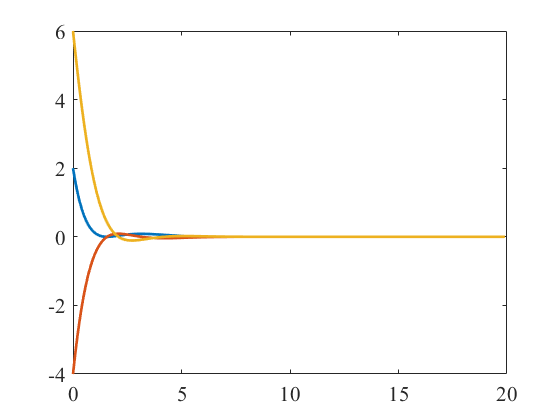

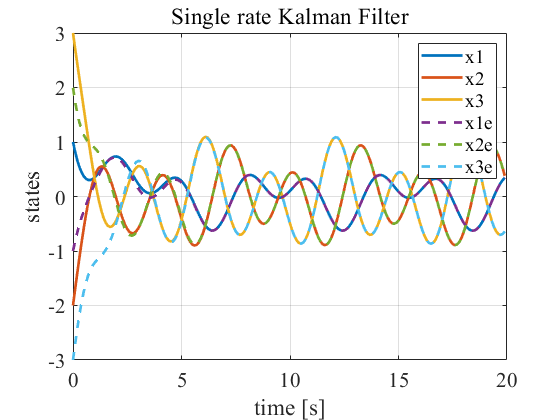

In [99]:
fig=figure;
plot(time,x_gt,time,x_obs5,'--')
legend('x1','x2','x3','x1e','x2e','x3e')
title('Single rate Kalman Filter')
grid on
xlabel('time [s]')
ylabel('states')
SaveFigPDF(fig,'SingleRateKF.pdf')


figure
plot(time,x_gt-x_obs5)

In [98]:
P_obs5_kf(:,:,end)
P_obs5_kf_red(:,:,end)

sysd.A\X/sysd.A'


ans =

   1.0e-33 *

    0.1085    0.0630   -0.1466
    0.0630    0.0099   -0.0728
   -0.1466   -0.0728    0.1950


ans =

   1.0e-19 *

    0.2859   -0.0170   -0.2367
   -0.0170    0.0010    0.0140
   -0.2367    0.0140    0.1960


ans =

   1.0e-16 *

    0.0011   -0.0069    0.0353
   -0.0069   -0.0180    0.1190
    0.0353    0.1190    0.0748




In [94]:
sysd.A*P_obs5_kf(:,:,end)*sysd.A'
X


ans =

   1.0e-19 *

    0.2611   -0.0365   -0.1979
   -0.0365    0.0051    0.0276
   -0.1979    0.0276    0.1500


X =

   1.0e-17 *

    0.0000   -0.0392    0.3712
   -0.0392    0.0328    0.9227
    0.3712    0.9227   -0.3332




In [100]:
Kc
G'


Kc =

   1.0e-31 *

    0.0896    0.0130
    0.0521    0.0020
   -0.1211   -0.0150


ans =

   1.0e-15 *

   -0.0018   -0.0066
   -0.0055    0.0231
    0.2336    0.1371




dare - 離散時間代数リカッチ方程式 (DARE) を解く

    この MATLAB 関数 は、離散時間代数リカッチ (Riccati) 方程式の固有な安定解 X を計算します。

    [X,L,G] = dare(A,B,Q,R)
    [X,L,G] = dare(A,B,Q,R,S,E)
    [X,L,G,report] = dare(A,B,Q,...)
    [X1,X2,L,report] = dare(A,B,Q,...,'factor')

    参考 care, dlyap, gdare

    Doc Center のリファレンス ページ
       doc dare





In [104]:
P_obs5_kf


P_obs5_kf(:,:,1) =

   1.0e-16 *

    0.0011   -0.0069    0.0353
   -0.0069   -0.0180    0.1190
    0.0353    0.1190    0.0748


P_obs5_kf(:,:,2) =

   1.0e-17 *

    0.0000   -0.0392    0.3712
   -0.0392    0.0328    0.9227
    0.3712    0.9227   -0.3332


P_obs5_kf(:,:,3) =

   1.0e-17 *

   -0.0033    0.0084    0.3456
    0.0084    0.1847    0.5945
    0.3456    0.5945   -0.7384


P_obs5_kf(:,:,4) =

   1.0e-17 *

    0.0039    0.0634    0.2803
    0.0634    0.2720    0.2861
    0.2803    0.2861   -0.7527


P_obs5_kf(:,:,5) =

   1.0e-17 *

    0.0219    0.1161    0.1868
    0.1161    0.3032    0.0375
    0.1868    0.0375   -0.5689


P_obs5_kf(:,:,6) =

   1.0e-17 *

    0.0497    0.1595    0.0786
    0.1595    0.2919   -0.1378
    0.0786   -0.1378   -0.3116


P_obs5_kf(:,:,7) =

   1.0e-17 *

    0.0848    0.1892   -0.0315
    0.1892    0.2528   -0.2420
   -0.0315   -0.2420   -0.0557


P_obs5_kf(:,:,8) =

   1.0e-17 *

    0.1243    0.2035   -0.1332
    0.2035    0.1991   -0.2861


In [105]:
W


W =

    0.0121         0
         0    0.0484




In [8]:
A_=sysd.A;
B_=sysd.B;
C_=sysd.C;
D_=sysd.D;

C


C =

     1     0     0
     0     1     0




In [27]:
RealPart =10*2*pi;
len = 100;

Ks = zeros(3,len);
Pends = zeros(3,len);
Omega = diag([0.1, 0.2]);

for i = 1:len

c_pole = 0.1*[i*1j,0,-i*1j]-RealPart;

d_pole = exp(ST*c_pole);
K = place(A',C',d_pole)';

Pend=dlyap(A-K*C*Aszx,K*Omega*K');
Pends(:,i)=reshape(diag(Pend),3,1);

end

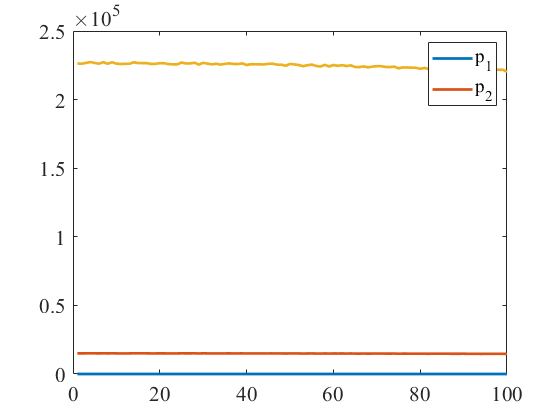

In [28]:
figure
xl = reshape(1:len,len,1);

plot(xl,Pends')
legend('p_1','p_2')


In [15]:
[X,L,G,report] = dare(A',C',zeros(size(A)),Omega)


X =

    0.1000   -0.1333    0.0667
   -0.1333    0.2889   -0.3111
    0.0667   -0.3111    0.4889


L =

  -0.5000 + 0.5000i
  -0.5000 - 0.5000i
  -1.0000 + 0.0000i


G =

   -0.3333   -0.1111    0.8889
    0.5000   -0.6667    0.3333


report =

   2.1820e-16




In [24]:
eig(A-G'*C)


ans =

  -0.5000 + 0.5000i
  -0.5000 - 0.5000i
  -1.0000 + 0.0000i




In [22]:
K


K =

    1.0000   -0.4410
   -0.9391    1.0000
   -4.0000   -4.8781


